# Preparation of SSCx analysis with topological sampling pipeline
[https://github.com/BlueBrain/topological_sampling](https://github.com/BlueBrain/topological_sampling)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import pandas as pd
import scipy.sparse as sps
from bluepy import Simulation, Cell, Synapse

ModuleNotFoundError: No module named 'bluepy'

## Data preparation
- Neuron info (hex0 target): __neuron_info.pickle__
- Spikes (hex0 target; EXC only): __raw_spikes.npy__
- Stimulus train: __stim_stream.npy__
- Adjacency matrix (hex0 target; re-indexed): __connectivity.npz__

In [2]:
sim_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/43269208-a4e3-4b21-9d25-fa97c23399d9/0' # Simplified connectome models (5th order)
# sim_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/c5ec762f-4146-43ae-be66-873ab1434087/0' # Simplified connectome models (4th order)
# sim_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/2afaaa6c-8c86-4aea-82b7-d493930fa451/0' # Simplified connectome models (3rd order)
# sim_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/abc8c760-839b-40d2-aaf8-efd8e9b2639b/0' # Simplified connectome models (2nd order)
# sim_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/8165329d-f63c-4b50-adb7-f282f2b3f3b4/0' # Simplified connectome models (1st order)
# sim_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/2bc672d4-1f3a-413d-bcff-1a4f6ccd7516/0' # Simplified connectome models (base)

# sim_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/b0a99807-f1c4-41e0-a261-5fb4e718412d/000'
# sim_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/f553e919-2fac-460c-a58e-3facc388da90/000'
save_path = os.path.join(sim_path, 'toposample_input')
if not os.path.exists(save_path):
    os.makedirs(save_path)

blue_config = os.path.join(sim_path, 'BlueConfig')
sim = Simulation(blue_config)
c = sim.circuit
hex0 = c.cells.ids('hex0')

spike_file = os.path.abspath(os.path.join(sim_path, sim.config['Stimulus_spikeReplay']['SpikeFile']))
spike_config_file = os.path.splitext(spike_file)[0] + '.json'
assert os.path.exists(spike_config_file), 'ERROR: Spike config file not found!'
with open(spike_config_file, 'r') as f:
    spike_config = json.load(f)

In [3]:
# Neuron info
neuron_info = c.cells.get(hex0, properties=[Cell.X, Cell.Y, Cell.Z, Cell.LAYER, Cell.MTYPE, Cell.SYNAPSE_CLASS])
neuron_info.to_pickle(os.path.join(save_path, 'neuron_info.pickle'))
neuron_info.to_hdf(os.path.join(save_path, 'neuron_info.h5'), 'neuron_info', format='table')

/gpfs/bbp.cscs.ch/home/pokorny/BbpWorkflowKernel/lib/python3.9/site-packages/tables/file.py:411: UserWarning: a closed node found in the registry: ``/neuron_info/meta/values_block_3/meta/_i_table``
  warnings.warn("a closed node found in the registry: "


In [4]:
# Excitatory spikes
hex0_exc = neuron_info[neuron_info['synapse_class'] == 'EXC'].index
raw_spikes = sim.spikes.get(hex0_exc)
raw_spikes = np.vstack((raw_spikes.index, raw_spikes.to_numpy())).T
np.save(os.path.join(save_path, 'raw_spikes.npy'), raw_spikes)

/gpfs/bbp.cscs.ch/ssd/apps/bsd/2022-01-10/stage_applications/install_gcc-11.2.0-skylake/py-numpy-1.19.5-gjm7kk/lib/python3.9/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
# Stim train
stim_stream = np.array(spike_config['props']['stim_train'])
np.save(os.path.join(save_path, 'stim_stream.npy'), stim_stream)

In [6]:
# Adjacency matrix
conns = np.array(list(c.connectome.iter_connections(pre=hex0, post=hex0)))
reindex_table = sps.csr_matrix((np.arange(neuron_info.shape[0], dtype=int), (np.zeros(neuron_info.shape[0], dtype=int), neuron_info.index.to_numpy())))
conns_reindex = np.array([reindex_table[0, conns[:, d]].toarray().flatten() for d in range(conns.shape[1])]).T

adj_matrix = sps.csc_matrix((np.full(conns_reindex.shape[0], True), conns_reindex.T.tolist()))
sps.save_npz(os.path.join(save_path, 'connectivity.npz'), adj_matrix)

In [7]:
print(f'INFO: Toposample input files written to "{save_path}": {os.listdir(save_path)}')

INFO: Toposample input files written to "/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/43269208-a4e3-4b21-9d25-fa97c23399d9/0/toposample_input": ['neuron_info.pickle', 'neuron_info.h5', 'connectivity.npz', 'stim_stream.npy', 'raw_spikes.npy']


In [8]:
assert False, '*** STOP HERE ***'

AssertionError: *** STOP HERE ***

## Re-convert dataframe from .h5 to .pickle
- In case pickled dataframe has wrong protocol
- Should be saved with same python/pandas version as used in toposample analysis (e.g., using same venv)
- OPTIONAL: Coordinate system transformation

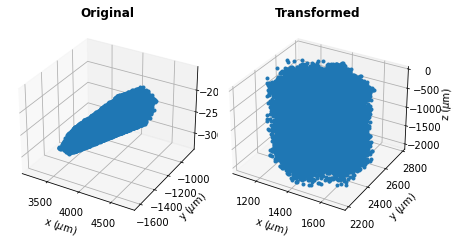

File written to /gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/43269208-a4e3-4b21-9d25-fa97c23399d9/0/toposample_input/neuron_info.pickle!


In [54]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from connectome_manipulator.model_building import model_types

save_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/43269208-a4e3-4b21-9d25-fa97c23399d9/0/toposample_input' # Simplified connectome models (5th order)
# save_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/c5ec762f-4146-43ae-be66-873ab1434087/0/toposample_input' # Simplified connectome models (4th order)
# save_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/2afaaa6c-8c86-4aea-82b7-d493930fa451/0/toposample_input' # Simplified connectome models (3rd order)
# save_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/abc8c760-839b-40d2-aaf8-efd8e9b2639b/0/toposample_input' # Simplified connectome models (2nd order)
# save_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/8165329d-f63c-4b50-adb7-f282f2b3f3b4/0/toposample_input' # Simplified connectome models (1st order)
# save_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/2bc672d4-1f3a-413d-bcff-1a4f6ccd7516/0/toposample_input' # Simplified connectome models (base)

# OPTIONAL: Coordinate system transformation based on position mapping model
# pos_map_fn = None
pos_map_fn = '/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/model_building/SSCx-Bio_M-20200805-HexO1/model/SSFlatPosMappingHexO1.json'

# camp_id = '4073e95f-abb1-4b86-8c38-13cf9f00ce0b'
# save_path = f'/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/analyses/proj96/{camp_id}/toposample_input_merged'
# save_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/b0a99807-f1c4-41e0-a261-5fb4e718412d/000/toposample_input'
h5_file = os.path.join(save_path, 'neuron_info.h5')
pickle_file = os.path.splitext(h5_file)[0] + '.pickle'
neuron_info = pd.read_hdf(h5_file)

if pos_map_fn is not None:
    pos_map = model_types.AbstractModel.model_from_file(pos_map_fn)
    plt.figure()
    plt.gcf().add_subplot(121, projection='3d')
    plt.plot(neuron_info['x'], neuron_info['y'], neuron_info['z'], '.')
    plt.gca().set_xlabel('x ($\mu$m)')
    plt.gca().set_ylabel('y ($\mu$m)')
    plt.gca().set_zlabel('z ($\mu$m)')
    plt.title('Original', fontweight='bold')
    new_pos = pos_map.apply(gids=neuron_info.index.to_numpy() - 1) # IMPORTANT: Index shift from BluePy indexing (1-based) to SONATA indexing (0-based)
    neuron_info = neuron_info.copy()
    neuron_info[['x', 'y', 'z']] = new_pos
    plt.gcf().add_subplot(122, projection='3d')
    plt.plot(neuron_info['x'], neuron_info['y'], neuron_info['z'], '.')
    plt.gca().set_xlabel('x ($\mu$m)')
    plt.gca().set_ylabel('y ($\mu$m)')
    plt.gca().set_zlabel('z ($\mu$m)')
    plt.title('Transformed', fontweight='bold')
    plt.tight_layout()
    plt.show()

if os.path.exists(pickle_file):
    os.rename(pickle_file, os.path.splitext(pickle_file)[0] + '_BAK_' + os.path.splitext(pickle_file)[1])
neuron_info.to_pickle(pickle_file)
print(f'File written to {pickle_file}!')

## Prepare working dir
- Creates empty copy of working dir
- Copies input files

In [12]:
import os
import shutil

# save_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/43269208-a4e3-4b21-9d25-fa97c23399d9/0/toposample_input' # Simplified connectome models (5th order)
# save_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/c5ec762f-4146-43ae-be66-873ab1434087/0/toposample_input' # Simplified connectome models (4th order)
# save_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/2afaaa6c-8c86-4aea-82b7-d493930fa451/0/toposample_input' # Simplified connectome models (3rd order)
# save_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/abc8c760-839b-40d2-aaf8-efd8e9b2639b/0/toposample_input' # Simplified connectome models (2nd order)
# save_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/8165329d-f63c-4b50-adb7-f282f2b3f3b4/0/toposample_input' # Simplified connectome models (1st order)
save_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/2bc672d4-1f3a-413d-bcff-1a4f6ccd7516/0/toposample_input' # Simplified connectome models (base)

template_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/toposample_working_dir_TEMPLATE_/'

tgt_dir = os.path.join(save_path, 'working_dir')

In [13]:
print(shutil.copytree(template_path, tgt_dir))
print(shutil.copy(os.path.join(save_path, 'neuron_info.pickle'), os.path.join(tgt_dir, 'data', 'input_data')))
print(shutil.copy(os.path.join(save_path, 'connectivity.npz'), os.path.join(tgt_dir, 'data', 'input_data')))
print(shutil.copy(os.path.join(save_path, 'stim_stream.npy'), os.path.join(tgt_dir, 'data', 'input_data')))
print(shutil.copy(os.path.join(save_path, 'raw_spikes.npy'), os.path.join(tgt_dir, 'data', 'input_data')))

/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/2bc672d4-1f3a-413d-bcff-1a4f6ccd7516/0/toposample_input/working_dir
/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/2bc672d4-1f3a-413d-bcff-1a4f6ccd7516/0/toposample_input/working_dir/data/input_data/neuron_info.pickle
/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/2bc672d4-1f3a-413d-bcff-1a4f6ccd7516/0/toposample_input/working_dir/data/input_data/connectivity.npz
/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/2bc672d4-1f3a-413d-bcff-1a4f6ccd7516/0/toposample_input/working_dir/data/input_data/stim_stream.npy
/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/2bc672d4-1f3a-413d-bcff-1a4f6ccd7516/0/toposample_input/working_dir/data/input_data/raw_spikes.npy


## Prepare m-type sections for random sampling

In [11]:
import numpy as np
mtypes = np.unique(neuron_info['mtype'])

In [ ]:
import json
nsamples = 25
dict_list = []
for mtype in mtypes:
    mtype_dict = {'name': mtype, 'value': {'column': 'mtype', 'value': mtype}, 'number': nsamples}
    dict_list.append(mtype_dict)
cfg_str = json.dumps([[dict_list]], indent=2) # Use nested lists to set correct indent
print(f'Config string for {len(mtypes)} m-types:')
print(cfg_str)

### Run toposample pipeline (manifold analysis only, based on volumetric/random samples)
- Use ToposampleKernel
- Current directory <code>/gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/topological_sampling<\code>
- Run on computation node (!)


In [19]:
# working_dir = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/43269208-a4e3-4b21-9d25-fa97c23399d9/0/toposample_input/working_dir' # Simplified connectome models (5th order)
# working_dir = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/c5ec762f-4146-43ae-be66-873ab1434087/0/toposample_input/working_dir' # Simplified connectome models (4th order)
# working_dir = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/2afaaa6c-8c86-4aea-82b7-d493930fa451/0/toposample_input/working_dir' # Simplified connectome models (3rd order)
# working_dir = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/abc8c760-839b-40d2-aaf8-efd8e9b2639b/0/toposample_input/working_dir' # Simplified connectome models (2nd order)
# working_dir = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/8165329d-f63c-4b50-adb7-f282f2b3f3b4/0/toposample_input/working_dir' # Simplified connectome models (1st order)
working_dir = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/2bc672d4-1f3a-413d-bcff-1a4f6ccd7516/0/toposample_input/working_dir' # Simplified connectome models (Base)

print('#<gen_topo_db>'.upper())
print(f'python pipeline/gen_topo_db/gen_topo_db.py {working_dir}/config/common_config.json "tribe"\n')
print(f'python pipeline/gen_topo_db/gen_topo_db.py {working_dir}/config/common_config.json "neuron_info"\n')
print(f'python pipeline/gen_topo_db/merge_database.py {working_dir}/config/common_config.json\n')

print('#<sample_tribes>'.upper())
print(f'python pipeline/sample_tribes/sample-tribes-random.py {working_dir}/config/common_config.json\n')
print(f'python pipeline/sample_tribes/sample-tribes-volumetric.py {working_dir}/config/common_config.json\n')

print('#<manifold_analysis>'.upper())
print(f'python pipeline/manifold_analysis/manifold_analysis.py {working_dir}/config/common_config.json "sampling=M-type"\n')
print(f'python pipeline/manifold_analysis/manifold_analysis.py {working_dir}/config/common_config.json "sampling=Radius"\n')

print('#<classifier>'.upper())
print(f'python pipeline/classifier/classifier.py {working_dir}/config/common_config.json components "sampling=M-type"\n')
print(f'python pipeline/classifier/classifier.py {working_dir}/config/common_config.json components "sampling=Radius"\n')

#<GEN_TOPO_DB>
python pipeline/gen_topo_db/gen_topo_db.py /gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/2bc672d4-1f3a-413d-bcff-1a4f6ccd7516/0/toposample_input/working_dir/config/common_config.json "tribe"

python pipeline/gen_topo_db/gen_topo_db.py /gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/2bc672d4-1f3a-413d-bcff-1a4f6ccd7516/0/toposample_input/working_dir/config/common_config.json "neuron_info"

python pipeline/gen_topo_db/merge_database.py /gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/2bc672d4-1f3a-413d-bcff-1a4f6ccd7516/0/toposample_input/working_dir/config/common_config.json

#<SAMPLE_TRIBES>
python pipeline/sample_tribes/sample-tribes-random.py /gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow/2bc672d4-1f3a-413d-bcff-1a4f6ccd7516/0/toposample_input/working_dir/config/common_config.json

python pipeline/